# Partitioning Schemes

In [1]:
import numpy as np
import pandas as pd
import random, copy
random.seed(0)

from functools import wraps
from time import perf_counter
from typing import Callable, Tuple, List

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

In [2]:
def get_random_order_list(n:int):
    """
    Given an integer n, creates a list containing first n natural 
    numbers. shuffles them randomly and returns the output
    """
    l = np.arange(1, n + 1).tolist()
    random.shuffle(l)
    return l

In [3]:
def timer(func:Callable) -> Callable:
    """
    Wrapper function to measure time for a function call
    """
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = perf_counter()
        results = func(*args, **kwargs)
        end = perf_counter()
        run_time = end - start
        return results, run_time

    return wrapper

In [4]:
def partition_lomuto(sublist:List, start:int, end:int):
    """
    Given a list, partitions it using lomuto's method
    using the start and end positions
    """
    # Take the last element as the pivot element
    pivot = sublist[end]
    
    # Start comparing from the beginning or the start of the list
    begin = start - 1
    
    # Move across the length of the provided sublist
    for current in range(start, end):
        # Whenever the current position element is lesser than pivot, then swap
        # the two elements
        if sublist[current] <= pivot:
            begin += 1
            sublist[current], sublist[begin] = sublist[begin], sublist[current]
    
    # Finally place the pivot in it's correct position
    sublist[end], sublist[begin + 1] = sublist[begin + 1], sublist[end]
    return (begin + 1)

def partition_hoare(sublist:List, start:int, end:int):
    """
    Given a list, partitions it using hoare's method
    using the start and end positions
    """
    pivot = sublist[start]
    i = start - 1
    j = end + 1
     
    
    while True:
        
        # Keep moving right till we find an element less than the pivot
        i += 1
        while (sublist[i] < pivot):
            i += 1
            
        # Keep moving left till we find an element greater than the pivot
        j -= 1
        while (sublist[j] > pivot):
            j -= 1 
            
        # Whenever the right and left pointers cross over, return
        # Right pointer to the calling function
        if i >= j:
            return j
        
        # Otherwise swap the left and right pointer contents
        sublist[i], sublist[j] = sublist[j], sublist[i]
    
    return j

@timer
def quicksort(l, start, end, partition_type = "lomuto"):
    """
    Given a list, the start and end indexes of the list and
    the partitioning scheme, sorts the list using quicksort.
    """
    # As long as end and start don't cross each other
    if start < end:
        # Perform partitioning and get the index of pivot 
        # which will be placed in final position
        if partition_type == "lomuto":
            part_index = partition_lomuto(l, start, end)
        else:
            part_index = partition_hoare(l, start, end)
        
        # Recursively call quicksort on left and right partitions
        # Pass in which method to use for partition as an argument
        if partition_type == "lomuto":
            quicksort(l, start, part_index - 1, partition_type)
        else:
            quicksort(l, start, part_index, partition_type)
        
        quicksort(l, part_index + 1, end, partition_type)

In [5]:
random.seed(10)
all_records = []

for ip_size in np.arange(5000, 10000001, 500000):
    # Create a list and it's copy
    l = get_random_order_list(ip_size)
    original_l = copy.deepcopy(l)
    start, end = 0, len(l) - 1
    
    # Sort the lists using hoare's and lomuto's partitioning schemes
    _, lomuto_runtime = quicksort(l, start, end)
    _, hoare_runtime = quicksort(original_l, start, end, "hoare")
    
    # Accumulate the result into a list 
    all_records.append([ip_size, lomuto_runtime, "Lomuto"])
    all_records.append([ip_size, hoare_runtime, "Hoare"])

In [6]:
# Create a dataframe of the results and display last few entries
results = pd.DataFrame(all_records, columns = ["InputSize", "Time", "Method"])
results.tail()

,InputSize,Time,Method
35,8505000,35.369598,Hoare
36,9005000,37.709283,Lomuto
37,9005000,38.183236,Hoare
38,9505000,40.508976,Lomuto
39,9505000,38.819216,Hoare


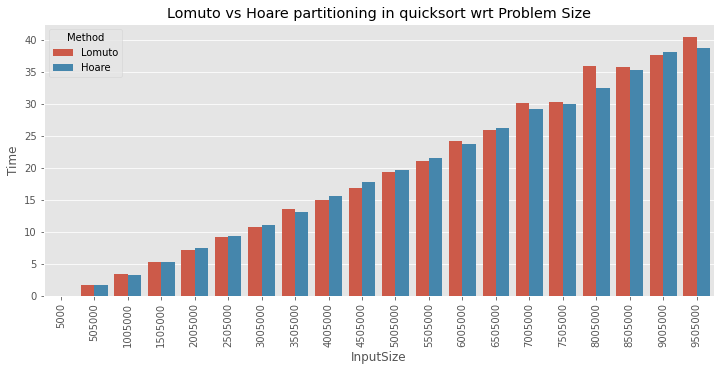

In [7]:
# Lomuto vs Hoare comparison plot
fig, ax = plt.subplots(1, 1, figsize = (12,5))
sns.barplot(x = "InputSize", y = "Time", data = results, hue = "Method", ax = ax)#, cmap = "YlGnBu")
plt.xticks(rotation = 90);
plt.title("Lomuto vs Hoare partitioning in quicksort wrt Problem Size");

# Hoare's method v/s Lomuto's method of Partitioning

`Hoare's Partition` and `Lomuto's Partition` are both methods which are employed in QuickSort algorithm for recursively reducing the problem by partitioning the problem into smaller sub-problems.

In the code above, we are looking at how performance is affected when we use one method vs another.

Both the methods have a best time complexity of `O(nlogn)` and a worst case time complexity of `O(n^2)`. But from the above chart, we can see that *Hoare's method is most often taking slightly more time than Lomuto's method*. Why is this?

In Hoare's method, we use two pointers right and left and we keep moving them toward one another until they cross. 

In Lomuto's method we start at one end and go to other end when partitioning. 

In some sense, we could say that Hoare's partitioning needs bidirectional element access and Lomuto's needs only one directional (As also seen from the code).

This means in Lomuto's method, we can intuitively imagine that memory amortization will work better as spatial locality will be exploited to the fullest. In Hoare's method also it will be exploited but the front and back elements would be loaded into the cache simultaneously so the effective portions of array to the left and right that are loaded in the cache memory from RAM would be smaller in a sense...

From a locality of reference perspective therefore, Lomuto's method outperforms Hoare's method.

**Interesting fact**: However, theoritically, when we study the two algorithms, the expected value of number of comparisons that happen in hoare's algorithm is three times lower than lomuto's algorithm, [Full discussion here](https://cs.stackexchange.com/a/11550). But practically as we see above, Lomuto's method is slightly faster in practise (Despite both having the same time complexity).

So, some of our high number of element lists sometimes show better performance with Hoare than with Lomuto.